In [4]:
from IPython.display import Image, display
from mlflow.tracking import MlflowClient
from plotly.subplots import make_subplots
import base64
import json
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

In [5]:
# Настройка MLflow
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

In [6]:
# 1. Получение информации об экспериментах
experiments = mlflow.search_experiments()
print("Доступные эксперименты:")
for exp in experiments:
    print(f"- {exp.name} (ID: {exp.experiment_id})")

# 2. Получение запусков только с моделями
experiment = client.get_experiment_by_name("California Housing Prediction")
all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Фильтрация run'ов с моделями
runs_with_models = []
for _, run in all_runs.iterrows():
    try:
        # Проверяем наличие артефактов модели
        artifacts = client.list_artifacts(run.run_id)
        has_model = not any(artifact.path.startswith("report") for artifact in artifacts)
        if has_model:
            runs_with_models.append(run)
    except Exception as e:
        print(f"Ошибка при проверке артефактов для run {run.run_id}: {e}")

runs = pd.DataFrame(runs_with_models)

print(f"\nВсего запусков: {len(all_runs)}")
print(f"Запусков с моделями: {len(runs)}")

Доступные эксперименты:
- California Housing Prediction (ID: 1)
- Default (ID: 0)

Всего запусков: 7
Запусков с моделями: 6


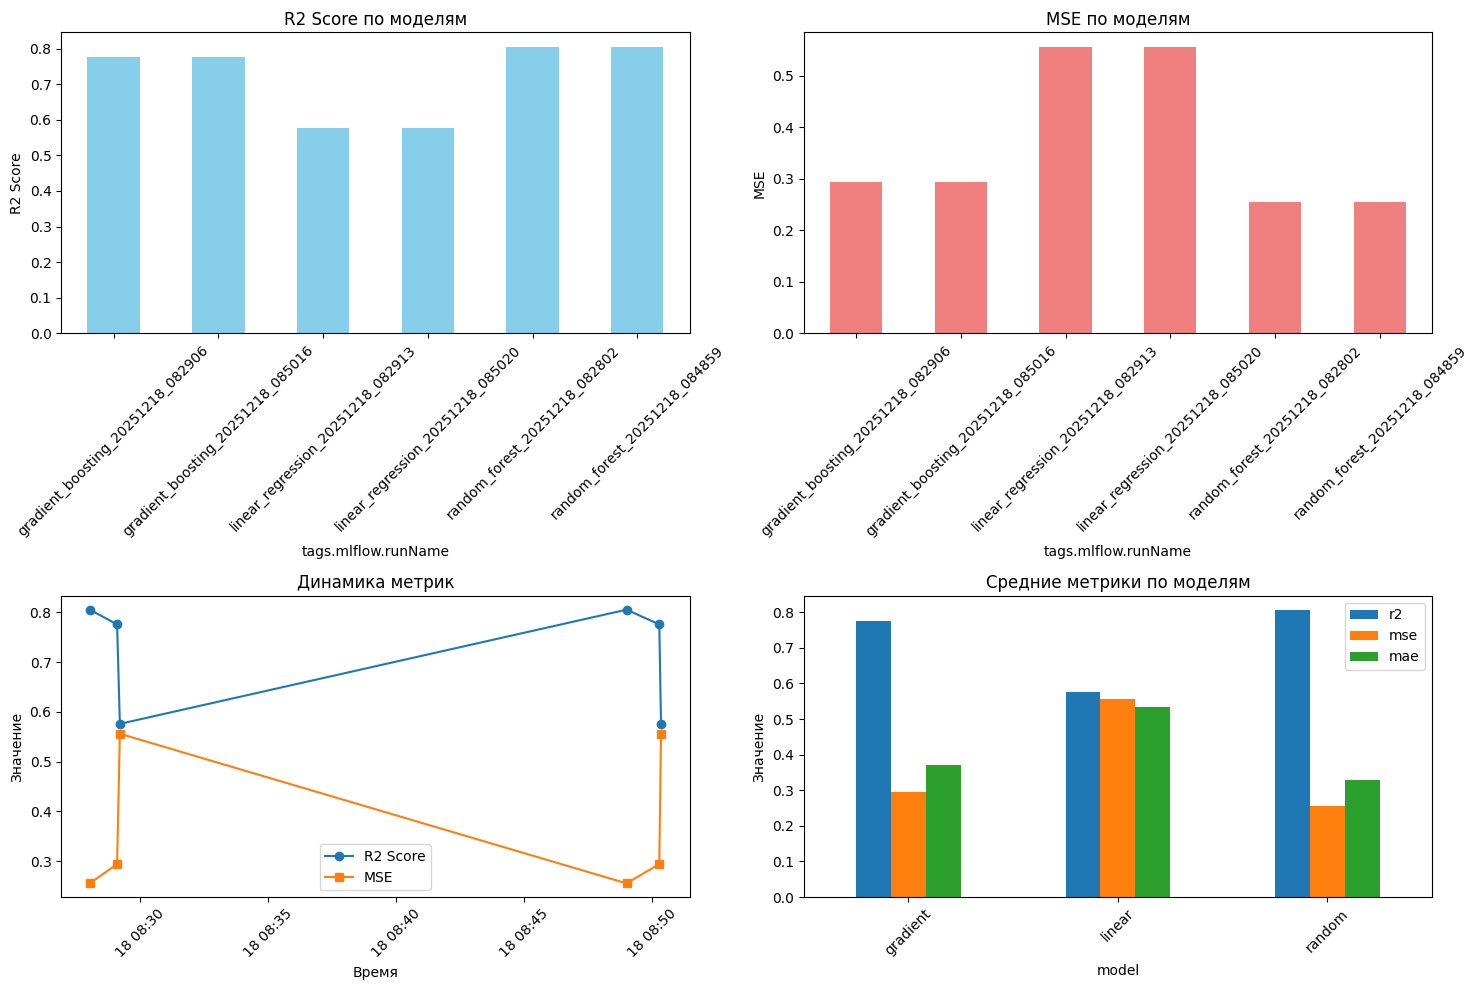

In [7]:
# 3. Визуализация метрик
plt.figure(figsize=(15, 10))

# R2 score по моделям
plt.subplot(2, 2, 1)
model_r2 = runs.groupby("tags.mlflow.runName")["metrics.r2_score"].max()
model_r2.plot(kind="bar", color="skyblue")
plt.title("R2 Score по моделям")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)

# MSE по моделям
plt.subplot(2, 2, 2)
model_mse = runs.groupby("tags.mlflow.runName")["metrics.mse"].min()
model_mse.plot(kind="bar", color="lightcoral")
plt.title("MSE по моделям")
plt.ylabel("MSE")
plt.xticks(rotation=45)

# Временная динамика метрик
plt.subplot(2, 2, 3)
runs["start_time"] = pd.to_datetime(runs["start_time"])
latest_runs = runs.sort_values("start_time").tail(10)
plt.plot(
    latest_runs["start_time"],
    latest_runs["metrics.r2_score"],
    marker="o",
    label="R2 Score",
)
plt.plot(latest_runs["start_time"], latest_runs["metrics.mse"], marker="s", label="MSE")
plt.title("Динамика метрик")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.xticks(rotation=45)

# Сравнение моделей
plt.subplot(2, 2, 4)
comparison_data = []
for idx, run in runs.iterrows():
    comparison_data.append(
        {
            "model": run["tags.mlflow.runName"].split("_")[0],
            "r2": run["metrics.r2_score"],
            "mse": run["metrics.mse"],
            "mae": run["metrics.mae"],
        }
    )

comparison_df = pd.DataFrame(comparison_data)
comparison_df.groupby("model").mean().plot(kind="bar", ax=plt.gca())
plt.title("Средние метрики по моделям")
plt.ylabel("Значение")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("./metrics_comparison.png")
plt.show()

In [8]:
# 4. Загрузка артефактов для последнего запуска
latest_run = runs.iloc[0]
run_id = latest_run.run_id

# Получение списка артефактов
artifacts = client.list_artifacts(run_id)
print("\nАртефакты последнего запуска:")
for artifact in artifacts:
    print(f"- {artifact.path}")


Артефакты последнего запуска:


In [9]:
# 5. Загрузка и отображение графиков

# Поиск графиков
plot_artifacts = [a for a in artifacts if "plots" in a.path and a.path.endswith(".png")]

print("\nГрафики из последнего запуска:")
for plot in plot_artifacts[:3]:  # Показать первые 3 графика
    try:
        # Загрузка изображения
        artifact_path = client.download_artifacts(run_id, plot.path)
        display(Image(filename=artifact_path))
        print(f"График: {plot.path}")
    except Exception as e:
        print(f"Ошибка загрузки {plot.path}: {e}")


Графики из последнего запуска:


In [10]:
# 6. Анализ параметров моделей
print("\nПараметры лучших моделей:")
best_models = runs.sort_values("metrics.r2_score", ascending=False).head(3)

for idx, run in best_models.iterrows():
    print(f"\nМодель: {run['tags.mlflow.runName']}")
    print(f"R2 Score: {run['metrics.r2_score']:.4f}")
    print(f"MSE: {run['metrics.mse']:.4f}")
    print(f"MAE: {run['metrics.mae']:.4f}")


Параметры лучших моделей:

Модель: random_forest_20251218_082802
R2 Score: 0.8053
MSE: 0.2552
MAE: 0.3274

Модель: random_forest_20251218_084859
R2 Score: 0.8053
MSE: 0.2552
MAE: 0.3274

Модель: gradient_boosting_20251218_082906
R2 Score: 0.7756
MSE: 0.2940
MAE: 0.3717


In [11]:
# 7. Создание интерактивной дашборда

# Создание интерактивного графика
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "R2 Score по моделям",
        "MSE по моделям",
        "Динамика R2 Score",
        "Сравнение метрик",
    ),
)

# График 1: R2 Score
fig.add_trace(
    go.Bar(x=model_r2.index, y=model_r2.values, name="R2 Score"), row=1, col=1
)

# График 2: MSE
fig.add_trace(go.Bar(x=model_mse.index, y=model_mse.values, name="MSE"), row=1, col=2)

# График 3: Динамика
fig.add_trace(
    go.Scatter(
        x=latest_runs["start_time"],
        y=latest_runs["metrics.r2_score"],
        mode="lines+markers",
        name="R2 Score",
    ),
    row=2,
    col=1,
)

# График 4: Сравнение
for metric in ["r2", "mse", "mae"]:
    fig.add_trace(
        go.Bar(
            x=comparison_df["model"].unique(),
            y=comparison_df.groupby("model")[metric].mean(),
            name=metric.upper(),
        ),
        row=2,
        col=2,
    )

fig.update_layout(height=800, showlegend=True, title_text="Анализ моделей MLflow")
fig.write_html("./model_analysis_dashboard.html")
print("\nИнтерактивная дашборда сохранена в model_analysis_dashboard.html")

# 8. Отчет о качестве моделей
print("\n" + "=" * 50)
print("ОТЧЕТ О КАЧЕСТВЕ МОДЕЛЕЙ")
print("=" * 50)

best_run = runs.iloc[runs["metrics.r2_score"].idxmax()]
worst_run = runs.iloc[runs["metrics.r2_score"].idxmin()]

print(f"\nЛучшая модель: {best_run['tags.mlflow.runName']}")
print(f"Лучший R2 Score: {best_run['metrics.r2_score']:.4f}")
print(f"\nХудшая модель: {worst_run['tags.mlflow.runName']}")
print(f"Худший R2 Score: {worst_run['metrics.r2_score']:.4f}")
print(
    f"\nРазница в качестве: {(best_run['metrics.r2_score'] - worst_run['metrics.r2_score']):.4f}"
)


Интерактивная дашборда сохранена в model_analysis_dashboard.html

ОТЧЕТ О КАЧЕСТВЕ МОДЕЛЕЙ

Лучшая модель: linear_regression_20251218_082913
Лучший R2 Score: 0.5758

Худшая модель: gradient_boosting_20251218_085016
Худший R2 Score: 0.7756

Разница в качестве: -0.1999
